In [95]:
import pandas as pd
import datetime as dt
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [96]:
files = ['cleaned_files/mortgage.csv','cleaned_files/immigration.csv','cleaned_files/house_price.csv']
dfs=[pd.read_csv(f,parse_dates=True)for f in files]

In [97]:
dfs


[     Mortgage_Rate     date
 0             5.59  2005-02
 1             5.60  2005-03
 2             5.67  2005-04
 3             5.55  2005-05
 4             5.31  2005-06
 ..             ...      ...
 198           3.20  2021-08
 199           3.22  2021-09
 200           3.29  2021-10
 201           3.40  2021-11
 202           3.45  2021-12
 
 [203 rows x 2 columns],
       immigrants     date
 0    18812.66667  2005-01
 1    18812.66667  2005-02
 2    18812.66667  2005-03
 3    24823.66667  2005-04
 4    24823.66667  2005-05
 ..           ...      ...
 199  40970.33333  2021-08
 200  40970.33333  2021-09
 201  46063.33333  2021-10
 202  46063.33333  2021-11
 203  46063.33333  2021-12
 
 [204 rows x 2 columns],
      Composite_HPI_SA  Composite_Benchmark_SA     date
 0               100.0                  221100  2005-01
 1               100.6                  222500  2005-02
 2               101.4                  224200  2005-03
 3               102.2                  225900  20

In [98]:
price_data =pd.merge(pd.merge(dfs[0],dfs[1],on='date'),dfs[2],on='date')
price_data

,Mortgage_Rate,date,immigrants,Composite_HPI_SA,Composite_Benchmark_SA
0,5.59,2005-02,18812.66667,100.6,222500
1,5.60,2005-03,18812.66667,101.4,224200
2,5.67,2005-04,24823.66667,102.2,225900
3,5.55,2005-05,24823.66667,102.8,227400
4,5.31,2005-06,24823.66667,103.8,229600
...,...,...,...,...,...
198,3.20,2021-08,40970.33333,326.5,721900
199,3.22,2021-09,40970.33333,333.9,738200
200,3.29,2021-10,46063.33333,343.5,759500
201,3.40,2021-11,46063.33333,351.4,777000


In [99]:
price_data['date'] = pd.to_datetime(price_data['date'])
#df = price_data.set_index('date') 
#df

#seperate dates for future plotting
train_dates = pd.to_datetime(price_data['date'])

In [100]:
#rearranging columns
price_data = price_data[['date', 'Mortgage_Rate', 'immigrants', 'Composite_HPI_SA', 'Composite_Benchmark_SA']]
price_data

,date,Mortgage_Rate,immigrants,Composite_HPI_SA,Composite_Benchmark_SA
0,2005-02-01,5.59,18812.66667,100.6,222500
1,2005-03-01,5.60,18812.66667,101.4,224200
2,2005-04-01,5.67,24823.66667,102.2,225900
3,2005-05-01,5.55,24823.66667,102.8,227400
4,2005-06-01,5.31,24823.66667,103.8,229600
...,...,...,...,...,...
198,2021-08-01,3.20,40970.33333,326.5,721900
199,2021-09-01,3.22,40970.33333,333.9,738200
200,2021-10-01,3.29,46063.33333,343.5,759500
201,2021-11-01,3.40,46063.33333,351.4,777000


In [101]:
df_for_training = price_data[["Mortgage_Rate","immigrants","Composite_HPI_SA","Composite_Benchmark_SA"]]
df_for_training

,Mortgage_Rate,immigrants,Composite_HPI_SA,Composite_Benchmark_SA
0,5.59,18812.66667,100.6,222500
1,5.60,18812.66667,101.4,224200
2,5.67,24823.66667,102.2,225900
3,5.55,24823.66667,102.8,227400
4,5.31,24823.66667,103.8,229600
...,...,...,...,...
198,3.20,40970.33333,326.5,721900
199,3.22,40970.33333,333.9,738200
200,3.29,46063.33333,343.5,759500
201,3.40,46063.33333,351.4,777000


In [102]:
#variables for training
#cols = list(price_data)[1:5]
#cols

In [103]:
#normalize the data
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [104]:
#LSTM model

trainX = []
trainY = []

n_future = 5
n_past = 24

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i+ n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}'.format(trainY.shape))

trainX shape == (175, 24, 4).
trainY shape == (175, 1)


In [105]:

trainX

array([[[ 1.06090489, -0.72956251, -1.59081233, -1.59018877],
        [ 1.07144282, -0.72956251, -1.57682929, -1.57674992],
        [ 1.14520834,  0.34763023, -1.56284625, -1.56331107],
        ...,
        [ 1.48242213, -0.62162221, -1.08567487, -1.08583659],
        [ 1.37704282, -0.62162221, -1.06120454, -1.06133045],
        [ 1.39811868, -1.24106927, -1.03673422, -1.03603379]],

       [[ 1.07144282, -0.72956251, -1.57682929, -1.57674992],
        [ 1.14520834,  0.34763023, -1.56284625, -1.56331107],
        [ 1.01875317,  0.34763023, -1.55235896, -1.55145326],
        ...,
        [ 1.37704282, -0.62162221, -1.06120454, -1.06133045],
        [ 1.39811868, -1.24106927, -1.03673422, -1.03603379],
        [ 1.49296006, -1.24106927, -1.00527237, -1.00520348]],

       [[ 1.14520834,  0.34763023, -1.56284625, -1.56331107],
        [ 1.01875317,  0.34763023, -1.55235896, -1.55145326],
        [ 0.76584283,  0.34763023, -1.53488016, -1.5340618 ],
        ...,
        [ 1.39811868, -1.24

In [106]:
trainY

array([[ 2.03039453],
       [ 2.12523591],
       [ 2.14631177],
       [ 2.13577384],
       [ 2.22007729],
       [ 2.26222901],
       [ 2.28330487],
       [ 2.34653246],
       [ 2.25169108],
       [ 2.12523591],
       [ 1.91447729],
       [ 1.71425661],
       [ 1.70371867],
       [ 1.8828635 ],
       [ 1.75640833],
       [ 1.66156695],
       [ 1.97770488],
       [ 2.03039453],
       [ 1.67210488],
       [ 1.26112558],
       [ 0.73422904],
       [ 0.586698  ],
       [ 0.21787042],
       [ 0.0387256 ],
       [ 0.33378766],
       [ 0.586698  ],
       [ 0.57616007],
       [ 0.40755318],
       [ 0.43916697],
       [ 0.50239456],
       [ 0.26002215],
       [ 0.22840835],
       [ 0.15464284],
       [ 0.13356698],
       [ 0.59723593],
       [ 0.7553049 ],
       [ 0.62884973],
       [ 0.46024283],
       [ 0.24948422],
       [ 0.01764974],
       [-0.06665371],
       [-0.14041923],
       [-0.08772957],
       [-0.03503992],
       [ 0.10195318],
       [ 0

In [108]:
#define autoencoder model
model =Sequential()
model.add(LSTM(64, activation='relu',input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation= 'relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 24, 64)            17664     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


In [109]:
#fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=True)

Epoch 1/10
10/10 [==============================] - 2s 48ms/step - loss: 0.7404 - val_loss: 0.9332
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 0.4440 - val_loss: 0.1558
Epoch 3/10
10/10 [==============================] - 0s 13ms/step - loss: 0.2929 - val_loss: 0.2019
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: 0.2105 - val_loss: 0.5000
Epoch 5/10
10/10 [==============================] - 0s 14ms/step - loss: 0.1590 - val_loss: 0.3558
Epoch 6/10
10/10 [==============================] - 0s 12ms/step - loss: 0.1316 - val_loss: 0.3765
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 0.1527 - val_loss: 0.3320
Epoch 8/10
10/10 [==============================] - 0s 13ms/step - loss: 0.1115 - val_loss: 0.3152
Epoch 9/10
10/10 [==============================] - 0s 13ms/step - loss: 0.1141 - val_loss: 0.3578
Epoch 10/10
10/10 [==============================] - 0s 13ms/step - loss: 0.1175 - val_loss: 0.2393


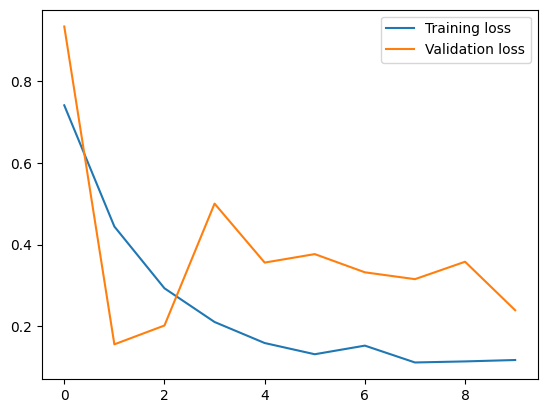

In [110]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [111]:
n_past = 16
n_days_for_prediction=15 

In [113]:
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction).tolist()
print(predict_period_dates)

[Timestamp('2020-09-01 00:00:00', freq='D'), Timestamp('2020-09-02 00:00:00', freq='D'), Timestamp('2020-09-03 00:00:00', freq='D'), Timestamp('2020-09-04 00:00:00', freq='D'), Timestamp('2020-09-05 00:00:00', freq='D'), Timestamp('2020-09-06 00:00:00', freq='D'), Timestamp('2020-09-07 00:00:00', freq='D'), Timestamp('2020-09-08 00:00:00', freq='D'), Timestamp('2020-09-09 00:00:00', freq='D'), Timestamp('2020-09-10 00:00:00', freq='D'), Timestamp('2020-09-11 00:00:00', freq='D'), Timestamp('2020-09-12 00:00:00', freq='D'), Timestamp('2020-09-13 00:00:00', freq='D'), Timestamp('2020-09-14 00:00:00', freq='D'), Timestamp('2020-09-15 00:00:00', freq='D')]


In [114]:
prediction = model.predict(trainX[-n_days_for_prediction:])

1/1 [==============================] - 0s 218ms/step


In [115]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [118]:
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'Composite_Benchmark_SA':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])


original = price_data[['date', 'Composite_Benchmark_SA']]
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2021-12-31']

sns.lineplot(original['date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])

c:\Users\prans\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


KeyError: 'Open'